In [1]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import torch.multiprocessing as mp
import random
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import datetime
import pytz
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from train_worker import main_worker
from dataset import CustomDataset

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 파라미터 설정

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
'''
# 맥 mps 설정
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")
'''

'\n# 맥 mps 설정\ndevice = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")\nprint(f"현재 디바이스는 {device} 입니다.")\n'

In [4]:
CFG = {
    'IMG_SIZE':1024,
    'EPOCHS':50,
    'LEARNING_RATE':1e-6,
    'BATCH_SIZE': 40,
    'SEED':41,
    'num_worker':12,
    'MEAN' : [0.485, 0.456, 0.406],
    'STD'  : [0.229, 0.224, 0.225],
    'train_magnification':"20X"
}

In [5]:
kst = pytz.timezone('Asia/Seoul')
current_datetime = datetime.datetime.now(kst)
day = current_datetime.strftime("%Y_%m_%d")
hour = current_datetime.strftime("%I:%M_%p")
print(day, hour)

2023_07_27 10:57_AM


In [6]:
# server path
output_path = f"/workspace/git_ignore/output/{day}"
pth_path = f"/workspace/git_ignore/pthfile/{day}"
train_data_path = f"/workspace/git_ignore/PDA_labeled_tile/train/{CFG['train_magnification']}/**/*.png"
val_data_path = f"/workspace/git_ignore/PDA_labeled_tile/validation/{CFG['train_magnification']}/**/*.png"

In [7]:
# server output name
pth_name = f"{pth_path}/M:{CFG['train_magnification']}_E:{CFG['EPOCHS']}_{hour}.pth"

In [8]:
# local path
'''
output_path = f"git_ignore/output/{day}"
pth_path = f"git_ignore/pthfile/{day}"
trainframe_path = f"{output_path}/trainframe"
train_data_path = f"git_ignore/PDA_mask_img/train/{CFG['train_magnification']}/**/*.png"
val_data_path = f"git_ignore/PDA_mask_img/validation_mask/{CFG['train_magnification']}/**/*.png"
'''

'\noutput_path = f"git_ignore/output/{day}"\npth_path = f"git_ignore/pthfile/{day}"\ntrainframe_path = f"{output_path}/trainframe"\ntrain_data_path = f"git_ignore/PDA_mask_img/train/{CFG[\'train_magnification\']}/**/*.png"\nval_data_path = f"git_ignore/PDA_mask_img/validation_mask/{CFG[\'train_magnification\']}/**/*.png"\n'

In [9]:
# local output name
'''
trainframe_name = f"{trainframe_path}/train:{CFG['train_magnification']}_epoch:{CFG['EPOCHS']}_{hour}.xlsx"
pth_name=f"{pth_path}/train:{CFG['train_magnification']}_epoch:{CFG['EPOCHS']}_{hour}.pth"
'''

'\ntrainframe_name = f"{trainframe_path}/train:{CFG[\'train_magnification\']}_epoch:{CFG[\'EPOCHS\']}_{hour}.xlsx"\npth_name=f"{pth_path}/train:{CFG[\'train_magnification\']}_epoch:{CFG[\'EPOCHS\']}_{hour}.pth"\n'

In [10]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 경로지정

In [11]:
train_path_list = sorted(glob.glob(train_data_path))
train_mask_path = train_path_list[0::2]
train_img_path = train_path_list[1::2]
train_mask_path[:5]

['/workspace/git_ignore/PDA_labeled_tile/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10073,w=1036,h=1036]-labelled.png',
 '/workspace/git_ignore/PDA_labeled_tile/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10603,w=1036,h=1036]-labelled.png',
 '/workspace/git_ignore/PDA_labeled_tile/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11133,w=1036,h=1036]-labelled.png',
 '/workspace/git_ignore/PDA_labeled_tile/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11663,w=1036,h=1036]-labelled.png',
 '/workspace/git_ignore/PDA_labeled_tile/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=12193,w=1036,h=1036]-labelled.png']

In [12]:
val_path_list = sorted(glob.glob(val_data_path))
val_mask_path = val_path_list[0::2]
val_img_path = val_path_list[1::2]
val_mask_path[:5]

['/workspace/git_ignore/PDA_labeled_tile/validation/20X/C3L-01662-23/C3L-01662-23 [d=1.01174,x=10360,y=10360,w=1036,h=1036]-labelled.png',
 '/workspace/git_ignore/PDA_labeled_tile/validation/20X/C3L-01662-23/C3L-01662-23 [d=1.01174,x=10360,y=11396,w=1036,h=1036]-labelled.png',
 '/workspace/git_ignore/PDA_labeled_tile/validation/20X/C3L-01662-23/C3L-01662-23 [d=1.01174,x=10360,y=12432,w=1036,h=1036]-labelled.png',
 '/workspace/git_ignore/PDA_labeled_tile/validation/20X/C3L-01662-23/C3L-01662-23 [d=1.01174,x=10360,y=13468,w=1036,h=1036]-labelled.png',
 '/workspace/git_ignore/PDA_labeled_tile/validation/20X/C3L-01662-23/C3L-01662-23 [d=1.01174,x=10360,y=14504,w=1036,h=1036]-labelled.png']

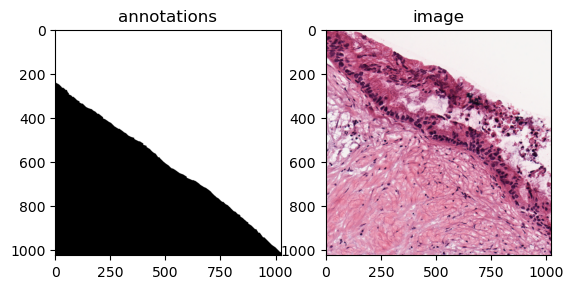

In [13]:
annotation = cv2.imread(train_mask_path[0])
image = cv2.imread(train_img_path[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.title("annotations")
plt.imshow(annotation)

plt.subplot(1,2,2)
plt.title("image")
plt.imshow(image)

## 데이터 불러오기

In [14]:
# transform
train_transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
        A.Normalize(mean=CFG['MEAN'], std = CFG['STD']),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        A.OneOf([
                A.HorizontalFlip(p=0.3),
                A.RandomRotate90(p=0.3),
                A.VerticalFlip(p=0.3)            
        ], p=0.3),
        ToTensorV2(transpose_mask=True)
])

'''
A.OneOf([
        A.MotionBlur(p=0.3),
        A.OpticalDistortion(p=0.3),
        A.GaussNoise(p=0.3)                 
], p=0.3),
'''

'\nA.OneOf([\n        A.MotionBlur(p=0.3),\n        A.OpticalDistortion(p=0.3),\n        A.GaussNoise(p=0.3)                 \n], p=0.3),\n'

In [15]:
val_transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
        A.Normalize(mean=CFG['MEAN'], std = CFG['STD']),
        ToTensorV2(transpose_mask=True)
])

In [16]:
# 학습용 데이터

train_set = CustomDataset(img_path = train_img_path,
                          mask_path = train_mask_path,
                          CFG = CFG,
                          transform = train_transform)

val_set = CustomDataset(img_path = val_img_path,
                         mask_path= val_mask_path,
                         CFG = CFG,
                         transform = val_transform)

In [17]:
print(f"train_data : {len(train_set)} / val_data : {len(val_set)}")

train_data : 6638 / val_data : 247


In [47]:
next(iter(val_set))

ValueError: operands could not be broadcast together with shapes (1024,1024) (3,) (1024,1024) 

## Run

In [18]:
world_size = torch.cuda.device_count()
mp.spawn(main_worker, nprocs=world_size, args=(world_size, train_set, val_set, CFG, pth_path, pth_name), join=True)

100%|██████████| 7/7 [00:19<00:00,  2.73s/it]


epoch1: Train_loss:0.85815304890275 Train_score:0.1697762362746289 Val_loss:0.8018566540309361 Val_score:0.2183781894189971


100%|██████████| 7/7 [00:18<00:00,  2.70s/it]


epoch2: Train_loss:0.8557864809408784 Train_score:0.16425533991424332 Val_loss:0.7957689932414463 Val_score:0.21963873292718614


 82%|████████▏ | 105/128 [02:05<00:24,  1.05s/it]

KeyboardInterrupt: 

 88%|████████▊ | 113/128 [02:12<00:13,  1.15it/s]